Uncomment and run the cell below if running on google cloud

In [1]:
# %cd Amazon-Reviews-Capstone

In [2]:
# importing library for loading
import pandas as pd
# pickle for faster loading of file
import pickle
# os to check files and paths
import os

In [3]:
%%time

# check if the pkl file of the dataframe exists 
if (os.path.isfile('shoes.pkl')):
    # load if it exists
    with open('shoes.pkl', 'rb') as f:
        df = pickle.load(f)
else:
    # if it doesn't exist, load the tsv into df and save into pkl file for future use
    file_path = 'Shoes.tsv'
    df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')
    
    # Uncomment code below for when using google cloud
    # bucket_name = 'amazon_shoes_review'
    # file_path = 'gs://amazon_shoes_review/Shoes.tsv'

    with open('shoes.pkl', 'wb') as f:
        pickle.dump(df, f)

CPU times: total: 4.66 s
Wall time: 4.99 s


## Data Prep

In [4]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,18069663,R3P2HIOQCIN5ZU,B000XB31C0,265024781,Minnetonka Men's Double Deerskin Softsole Mocc...,Shoes,1,0,0,N,Y,.,Do not buy: really didn't start to wear them u...,2015-08-31
1,US,16251825,R12VVR0WH5Q24V,B00CFYZH5W,259035853,Teva Men's Pajaro Flip-Flop,Shoes,5,0,0,N,Y,super flip flop,provides great cushion as well as archsupport,2015-08-31
2,US,20381037,RNCCKB6TV5EEF,B00S8JNN3Q,666066660,Anne Klein Perfect Pair Wristlet,Shoes,4,0,0,N,Y,Great clutch purse!,It's perfect if you need something small for c...,2015-08-31
3,US,108364,R2NZXYIVCGB13W,B00XFBPOQG,448483263,adidas Men's 10K Lifestyle Runner Sneaker,Shoes,5,0,6,N,Y,Badass,Getting what u see,2015-08-31
4,US,45449350,R2EQ1TG9IT3OEQ,B00SW64Y9W,7853171,OverBling Sneakers for Men Casual Men Shoes Ge...,Shoes,3,0,0,N,Y,Three Stars,small,2015-08-31


In [5]:
df.shape

(4358820, 15)

There are 4358820 rows and 15 columns to the dataset. 

In [9]:
# Check for nulls
(df.isna().sum())/df.shape[0]

marketplace          0.000000e+00
customer_id          0.000000e+00
review_id            0.000000e+00
product_id           0.000000e+00
product_parent       0.000000e+00
product_title        2.294199e-07
product_category     0.000000e+00
star_rating          0.000000e+00
helpful_votes        0.000000e+00
total_votes          0.000000e+00
vine                 0.000000e+00
verified_purchase    0.000000e+00
review_headline      5.964917e-06
review_body          1.009448e-04
review_date          4.817818e-06
dtype: float64

Since the null values are significantly smaller than the dataset, it is fine to just drop those rows that have null values.

In [12]:
# Dropping the nulls
df = df.dropna()

In [13]:
# check for duplicates
df.duplicated().sum()

0

Luckily, there are no duplicates in this dataset

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# Generating a word cloud just to visualize the most common products and see if there are outliers
wc = ' '.join([text for text in df['product_title']])
wordcloud = WordCloud(width = 1000, height = 500, random_state = 1, max_font_size = 100).generate(wc)

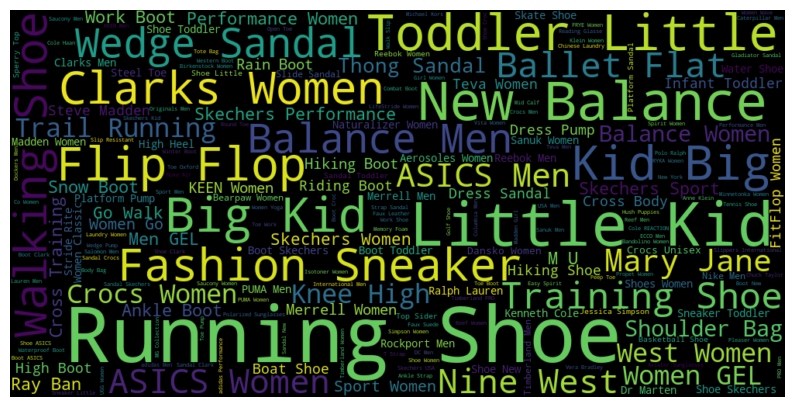

In [32]:
fig = plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [34]:
# Extract word frequencies from the word cloud
word_frequencies = wordcloud.words_
word_frequencies

{'Running Shoe': 1.0,
 'Little Kid': 0.5577493201752891,
 'New Balance': 0.4338985476626979,
 'Toddler Little': 0.3686149295640262,
 'Big Kid': 0.3505816846022259,
 'Kid Big': 0.33399668777133357,
 'Flip Flop': 0.3285001601592051,
 'Walking Shoe': 0.3056110244055367,
 'Fashion Sneaker': 0.3011265666637134,
 'Clarks Women': 0.29606962495484873,
 'Balance Men': 0.23766944503131623,
 'Wedge Sandal': 0.23401645209876712,
 'Training Shoe': 0.20339196750471958,
 'Ballet Flat': 0.19417770174948373,
 'ASICS Women': 0.1813070354190378,
 'Nine West': 0.17970885101104758,
 'ASICS Men': 0.17186786524817863,
 'Mary Jane': 0.1619618480327679,
 'Trail Running': 0.15870073400622917,
 'Crocs Women': 0.1580157978313762,
 'West Women': 0.15533739069986166,
 'Women GEL': 0.15493188122320742,
 'Knee High': 0.15435598961350516,
 'Shoulder Bag': 0.14987834715700374,
 'Balance Women': 0.14780650041914004,
 'Thong Sandal': 0.14604474916342372,
 'Skechers Sport': 0.14396267949757716,
 'Skechers Performance': 0.

It can be observed in the word cloud that the dataset does include shoes (with great vareity from flip flops to sneakers to boots) but also includes items that aren't shoes such as 'ray ban' and 'shoulder bag' and many more. To remove these non-shoe products, it will be manually removed if a certain keyword is in the product title so any products, for example, with `sunglasses` in the name will be searched for and removed. The list of words can be found in `common_others` variable which are the list of words that will be searched and remove the row if the product title contains any of these words.  

In [49]:
# removing products that are not shoes
common_others = [' bag ', 'sunglasses', 'wallet', 'ray ban', 'rayban', 'tote', 'handbag', 'purse', 'clutch', 'spinner', 'wrist'] 
label_others = df['product_title'].str.contains('|'.join(common_others), case=False, na=False)
df_others=df[label_others]

In [50]:
# removing the products from the dataframe
df = df[~label_others]

In [ ]:
df

In [ ]:
# removing products that are close to shoes but aren't 
common_others2 = ['polish', 'laces'] 
label_others2 = df['product_title'].str.contains('|'.join(common_others2), case=False, na=False)
df_others=df[label_others2]

In [ ]:
pd.set_option('display.max_colwidth', None)
df_others['product_title']

In [ ]:
df = df[~label_others2]

In [ ]:
df

In [ ]:
# Generating a word cloud just to visualize the most common products and see if there are outliers
wc = ' '.join([text for text in df['product_title']])
wordcloud = WordCloud(width = 1000, height = 500, random_state = 1, max_font_size = 100).generate(wc)

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

--- 

## Method 2: embedding to filter 
Below is an attempt to filter out shoes and outliers using embedding.

In [13]:
from sentence_transformers import SentenceTransformer

In [14]:
embedder = SentenceTransformer('bert-base-cased')

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

No sentence-transformers model found with name C:\Users\mager/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\mager/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model 

In [6]:
product_names = df['product_title']
product_names

0          Minnetonka Men's Double Deerskin Softsole Mocc...
1                                Teva Men's Pajaro Flip-Flop
2                           Anne Klein Perfect Pair Wristlet
3                  adidas Men's 10K Lifestyle Runner Sneaker
4          OverBling Sneakers for Men Casual Men Shoes Ge...
                                 ...                        
4358815                   Fox Men's Featherlite Shoe Lace-Up
4358816                                        Floor Spinner
4358817                                        Floor Spinner
4358818                                        Floor Spinner
4358819                                        Floor Spinner
Name: product_title, Length: 4358820, dtype: object

In [ ]:
corpus = list(product_names)
corpus = corpus[0:50000]
corpus

In [ ]:
%%time
corpus_embeddings = embedder.encode(corpus)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
%%time
num_clusters = 2
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [ ]:
cluster_df = pd.DataFrame(corpus, columns = ['corpus'])
cluster_df['cluster'] = cluster_assignment
cluster_df

In [16]:
common_shoes = ['running shoe', 'walking shoe', 'flip', 'sandal', 'sneaker'] #flip for flip flop

In [17]:
label_shoes = df['product_title'].str.contains('|'.join(common_shoes), case=False, na=False)
df_shoes=df[label_shoes]

In [23]:
test = ['flip flop']
label_test = df['product_title'].str.contains('|'.join(test), case=False, na=False)
df_test=df[label_test]

In [24]:
df_test

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
121,US,714880,R3T9CFXSPT84NT,B00SY2TIW2,945791678,Qupid Women's Glenn-04 Flip Flop,Shoes,5,0,0,N,Y,Five Stars,loved it,2015-08-31
209,US,50077336,R1OGKIISG91DN6,B00CE5MX68,329798902,Neat Feat Men's Zori Sport Orthotic Slip-On Sa...,Shoes,5,0,0,N,Y,Comfy,"Love these shoes, much more comfortable than o...",2015-08-31
266,US,6931773,R2HPBTALCSAH6U,B00OXTL4EA,974393885,Sperry Top-Sider Women's Seafish Core Flip Flop,Shoes,5,0,0,N,Y,The perfect flip-flops,These flip-flops are extremely comfortable and...,2015-08-31
313,US,39780501,R3N7L2HEQI37L2,B00U3ZCIQG,599473254,FitFlop Women's The Skinny Cork Leather Flip Flop,Shoes,5,0,0,N,Y,Five Stars,Love this style. Fit great and are very comfor...,2015-08-31
481,US,26150613,R2A8JV1WQV6ZUL,B007ZI7QOS,84610814,Crocs Women's Kadee Flip Flop,Shoes,3,0,0,N,Y,The on; y problem... they make ...,The on;y problem...they make my feet sweat.,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356773,US,28866506,R10BMT585R5M28,B0009IZWUQ,616589798,Billabong Gin Flip Flops,Shoes,4,0,0,N,N,"Not Reefs, BUT...",Rainbow's are comfey but JEEZ are they UGLY! ...,2005-06-24
4357228,US,26525110,R1WC18J5171155,B0002OFAT0,78167177,Whales Flip Flop,Shoes,3,1,1,N,N,They are okay,These shoes are great beach shoes!! But if you...,2005-01-01
4358059,US,46090689,R163MPIJPJ37BI,B00008NRFB,325351625,BRASIL FLIP FLOP,Shoes,5,1,1,N,N,Simply the best!,These Havaianas are the best flip flops ever m...,2003-05-20
4358151,US,40932882,R124H5Y9KJCZBE,B00008CRSE,38402634,PAUL FRANK JULIUS FLIP FLOPS,Shoes,4,1,2,N,N,Flip Flops,these are comfortable sandals and they do not ...,2003-04-11


In [9]:
common_others = [' bag ', 'sunglasses', 'wallet', 'ray ban', 'rayban', 'tote', 'handbag', 'purse', 'clutch'] 

In [10]:
label_others = df['product_title'].str.contains('|'.join(common_others), case=False, na=False)
df[label_others]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
14,US,37235551,R3AM24QPLI28UY,B00LAVB1TC,910150896,Travel Smart Hand Pouch Bag In Bag Organiser C...,Shoes,2,1,2,N,Y,Two Stars,It's okay .,2015-08-31
22,US,11715430,RW4TDN6I1NTAN,B00DW0IEEE,233583302,Studded Flat Top Sunglasses Bold Square DG Fas...,Shoes,5,0,0,N,Y,Five Stars,Absolutely love!!,2015-08-31
23,US,37806883,R132P1Y7J9WJAJ,B002XKQ2YI,165641142,Baggallini Town Tote -Giraffe Printed,Shoes,5,0,0,N,Y,Never travel without it!!,Very sturdy. A great travel tote - lots of poc...,2015-08-31
51,US,1737676,R3EQ1M3MYK3KOI,B00F4LIOGC,485902662,zeroUV - Retro Half Frame Semi-Rimless P3 Roun...,Shoes,4,0,0,N,Y,This was a bit disappointing to me but otherwi...,They're a lot darker than pictured. If backlit...,2015-08-31
55,US,11427865,R54ERC8XK72IF,B010EGGRY2,399707862,MyLux® Women Fashion Designer Rhinestone Studs...,Shoes,4,9,9,N,Y,Missing rhinestones small opening!,"i do love the sparkle of this bag,,,after all...",2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4358692,US,51346793,R38R4VWOW4VZN1,B000078QJV,231639765,Nostalgia Retriever Clutch,Shoes,5,4,5,N,N,My Love Affair with the Nostalgia Collection,These are the most beautiful wallets and cigar...,2002-11-10
4358696,US,50235199,R27FF6SLPGQZI9,B000078QJV,231639765,Nostalgia Retriever Clutch,Shoes,5,6,6,N,N,"Great value, excellent features!","A great wallet, that I loved everything about ...",2002-11-10
4358702,US,36524015,R2PEG4XZOM9WKM,B000073370,936961228,Liz Claiborne Soft Smooth Zip Leather Clutch,Shoes,3,0,0,N,N,clutches -of -all- clutches,"HAS EVERYTHING FOR CHECKBOOK,CREDIT CARDS AND ...",2002-11-10
4358774,US,48916473,R1DH84PBWLFP3L,B00006UE1D,32601320,Merrell 'Topo Clutch' Mary Jane Slide (Women),Shoes,5,2,2,N,N,Topo clutch clog hip and cool,I got my topo clutch clog in the summer to we...,2002-11-03


In [20]:
df_shoes[label_others]

C:\Users\mager\AppData\Local\Temp\ipykernel_1328\634864073.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_shoes[label_others]


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
738,US,7508233,R1XUTFPAONKYPQ,B003IJ6HFM,979740266,"Sof Sole Sneaker Balls Shoe, Gym Bag and Locke...",Shoes,5,0,0,N,Y,Takes the oder away,They aren't sneakers but these balls help the ...,2015-08-31
1090,US,15072868,R2SQB6V5HOV6VZ,B003IJ6HFM,979740266,"Sof Sole Sneaker Balls Shoe, Gym Bag and Locke...",Shoes,5,0,0,N,Y,Wish I knew about this things back in the day ...,Wish I knew about this things back in the day....,2015-08-31
2414,US,42189397,RE3GDM0SU1EFK,B005P1KYTQ,561163831,zeroUV - Small Retro Steampunk Circle Flip Up ...,Shoes,5,0,0,N,Y,Absolutely loved them! I went to Lenscrafter a...,Absolutely loved them! I went to Lenscrafter a...,2015-08-31
2466,US,9135543,R1HJH6ZWYD37U4,B00O7ENMU0,342640214,Besgoods Polarized Clip-on Flip up Metal Clip ...,Shoes,5,0,0,N,Y,Five Stars,good price,2015-08-31
3924,US,31670612,RQF1RIH9K3WBN,B005P1KY8M,561163831,zeroUV - Small Retro Steampunk Circle Flip Up ...,Shoes,5,0,0,N,Y,Five Stars,Nice,2015-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4311220,US,52644804,R1O7NCNHNIMI72,B001AVDSBG,940945309,Backpack Purse Sling Hobo Handbag - Choice Col...,Shoes,5,1,1,N,N,Great Service,Product arrived very quickly and in great cond...,2008-06-20
4311633,US,12013937,R306YVSYHZYDIB,B0017D2LG0,982805176,GARGOYLES FLIP8 ROVER BLACK SMOKE BASEBALL SUN...,Shoes,5,1,1,N,N,Great Flippers!,Altho these sunglasses are made for baseball p...,2008-06-16
4316159,US,20955632,R3NJX6PTMPCJBL,B0014W9OTQ,304175468,Chadwicks Totes Sport Sneaker Flats,Shoes,5,0,0,N,N,Very Cute,"First off, Make sure you order a size down. I...",2008-04-23
4341076,US,33814635,RIIO9ZBL7M2B5,B000FFTAME,528017521,Pink Flip Flops Finders Key Purse Key Chain,Shoes,5,0,0,N,Y,Great time saver!,This little key finder key chain for my purse ...,2007-05-16


In [ ]:
# creating a dataframe with just product names
df_names = df['product_title']
df_others = pd.DataFrame(df_names[label_others]) #pd.Dataframe is needed to add the column label after
df_shoes = pd.DataFrame(df_names[label_shoes])
df_others['label'] = 'others'
df_shoes['label'] = 'shoes'

In [ ]:
# combining and removing products that have shoes and others tag
combined_df = pd.concat([df_others, df_shoes])
filtered_df = combined_df[~(label_others & label_shoes)]

In [ ]:
common_shoes = ['running shoe', 'walking shoe', 'flip', 'sandal', 'sneaker', 'boot', 'crocs', 'skateboarding shoe', 'clog', 'hiking shoe', 'slipper', 'flat', 'pump', 'shoe'] #flip for flip flop

In [ ]:
label_shoes = df['product_title'].str.contains('|'.join(common_shoes), case=False, na=False)
df_shoes=df[label_shoes]

In [ ]:
# Create a boolean mask indicating rows in df1 that are not present in df2
mask = ~df.isin(df_shoes)

# Filter df1 using the mask to get rows not in df2
result = df[mask]

In [ ]:
# Print the result

list(result.dropna()['product_title'].unique())

In [ ]:
df_shoes['product_title']

In [ ]:
clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])
    
for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [21]:
def word_cloud(pred_df, label):
    wc = ' '.join([text for text in pred_df['corpus'][pred_df['cluster'] == label]])
    wordcloud = WordCloud(width = 800, height = 500, random_state = 20, max_font_size = 110).generate(wc)
    fig7 = plt.figure(figsize=(10,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [22]:
word_cloud(cluster_df, 0)

NameError: name 'cluster_df' is not defined

In [ ]:
word_cloud(cluster_df, 1)

In [ ]:
labeled_embeddings = embedder.encode(filtered_df)

In [ ]:
%%time
corpus_embeddings = embedder.encode(corpus)

In [ ]:
%%time
num_clusters = 2
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_